In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import joblib

In [3]:
# Load the dataset
data = pd.read_csv('fraud_detection.csv')

In [4]:
data

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


In [5]:
# Handle missing values or invalid placeholders
data.replace('?', np.nan, inplace=True)

In [6]:
# Drop columns with too many missing values (if any)
data.dropna(axis=1, thresh=len(data) * 0.9, inplace=True)

In [7]:

# Fill missing values with the mean for numeric columns and mode for categorical columns
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(data[col].mean())
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].fillna(data[col].mode()[0])

In [8]:
# Convert date columns to datetime
data['policy_bind_date'] = pd.to_datetime(data['policy_bind_date'], errors='coerce')
data['incident_date'] = pd.to_datetime(data['incident_date'], errors='coerce')

In [9]:
# Feature engineering
data['policy_to_incident_days'] = (data['incident_date'] - data['policy_bind_date']).dt.days
data['total_claim_ratio'] = (data['injury_claim'] + data['property_claim'] + data['vehicle_claim']) / data['total_claim_amount']

In [10]:
# Encoding categorical variables
categorical_columns = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
                       'insured_occupation', 'insured_hobbies', 'insured_relationship',
                       'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted',
                       'incident_state', 'incident_city', 'auto_make', 'auto_model']

In [11]:
# Keep only columns that exist in the dataset
categorical_columns = [col for col in categorical_columns if col in data.columns]

In [12]:
# Apply one-hot encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [13]:
# Label encoding for fraud
if 'fraud_reported' in data.columns:
    data['fraud_reported'] = data['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

In [14]:
# Drop unnecessary columns and split dataset
X = data.drop(['fraud_reported', 'policy_bind_date', 'incident_date', 'incident_location'], axis=1, errors='ignore')
y = data['fraud_reported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **Random Forest Classifier**


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [57]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

In [58]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nROC AUC Score:", rf_auc)

Confusion Matrix:
 [[215   5]
 [ 74   6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.84       220
           1       0.55      0.07      0.13        80

    accuracy                           0.74       300
   macro avg       0.64      0.53      0.49       300
weighted avg       0.69      0.74      0.65       300


ROC AUC Score: 0.8325


In [59]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 10 Important Features:")
for i in range(min(10, len(indices))):
    print(f"Feature {indices[i]}: Importance {importances[indices[i]]:.4f}")


Top 10 Important Features:
Feature 72: Importance 0.0548
Feature 71: Importance 0.0479
Feature 48: Importance 0.0444
Feature 15: Importance 0.0410
Feature 16: Importance 0.0356
Feature 4: Importance 0.0355
Feature 13: Importance 0.0354
Feature 6: Importance 0.0351
Feature 14: Importance 0.0327
Feature 2: Importance 0.0323


In [60]:
joblib.dump(rf_model, "rf_model.pkl")
print("Random Forest model saved as rf_model.pkl")

Random Forest model saved as rf_model.pkl


In [61]:
sample_rf = X_test.iloc[:1]
loaded_rf = joblib.load("rf_model.pkl")
pred_rf = loaded_rf.predict(sample_rf)
print(f"Random Forest Sample Prediction: {'Fraud' if pred_rf[0] == 1 else 'Not Fraud'}")

Random Forest Sample Prediction: Not Fraud


# **Logistic Regression**

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, y_pred_log)
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])


In [32]:
y_pred_log = log_model.predict(X_test_scaled)

In [33]:
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1]))

Logistic Regression Results
Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81       220
           1       0.47      0.42      0.45        80

    accuracy                           0.72       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.71      0.72      0.72       300

ROC AUC Score: 0.7373295454545455


In [66]:
joblib.dump(log_model, "logistic_model.pkl")
print("Logistic Regression model saved as logistic_model.pkl")

Logistic Regression model saved as logistic_model.pkl


In [67]:
sample_log = X_test_scaled[:1]
loaded_log = joblib.load("logistic_model.pkl")
pred_log = loaded_log.predict(sample_log)
print(f"Logistic Regression Sample Prediction: {'Fraud' if pred_log[0] == 1 else 'Not Fraud'}")

Logistic Regression Sample Prediction: Not Fraud


# **XG Boosting**

In [36]:
from xgboost import XGBClassifier
import joblib

In [68]:
xgb = XGBClassifier(eval_metric="logloss", scale_pos_weight=3)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

In [69]:
y_pred_xgb = xgb.predict(X_test)

In [70]:
print("--- XGBoost Results ---")
print(f"Accuracy: {xgb_accuracy}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")
print("ROC AUC Score:", xgb_auc)

--- XGBoost Results ---
Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       220
           1       0.60      0.53      0.56        80

    accuracy                           0.78       300
   macro avg       0.72      0.70      0.71       300
weighted avg       0.77      0.78      0.78       300

ROC AUC Score: 0.8229545454545455


In [40]:
joblib.dump(xgb, "xgb_model.pkl")
print("XGBoost model saved as xgb_model.pkl")

XGBoost model saved as xgb_model.pkl


In [71]:
sample_xgb = X_test.iloc[:1]
loaded_xgb = joblib.load("xgb_model.pkl")
pred_xgb = loaded_xgb.predict(sample_xgb)
print(f"XGBoost Sample Prediction: {'Fraud' if pred_xgb[0] == 1 else 'Not Fraud'}")


XGBoost Sample Prediction: Not Fraud


# **Naive Bayes**

In [42]:
from sklearn.naive_bayes import GaussianNB
import joblib

In [72]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_auc = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])

In [73]:
y_pred_nb = nb.predict(X_test)

In [74]:
print("Results: Naive Bayes")
print("Accuracy: ", nb_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("ROC AUC Score:", nb_auc)

Results: Naive Bayes
Accuracy:  0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80       220
           1       0.25      0.10      0.14        80

    accuracy                           0.68       300
   macro avg       0.49      0.50      0.47       300
weighted avg       0.60      0.68      0.63       300

ROC AUC Score: 0.5868749999999999


In [46]:
joblib.dump(nb, "naive_bayes_model.pkl")
print("Naive Bayes model saved as naive_bayes_model.pkl")

Naive Bayes model saved as naive_bayes_model.pkl


In [75]:
sample_nb = X_test.iloc[:1]
loaded_nb = joblib.load("naive_bayes_model.pkl")
pred_nb = loaded_nb.predict(sample_nb)
print(f"Naive Bayes Sample Prediction: {'Fraud' if pred_nb[0] == 1 else 'Not Fraud'}")


Naive Bayes Sample Prediction: Not Fraud


# **KNN Classification**

In [48]:
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [76]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])

In [77]:
y_pred_knn = knn.predict(X_test_scaled)

In [78]:
print("KNN Classification")
print(f"Accuracy Score: {knn_accuracy}")
print("Classification Report:\n{classification_report(y_test, y_pred_knn)}")
print("ROC AUC Score:", knn_auc)

KNN Classification
Accuracy Score: 0.6733333333333333
Classification Report:
{classification_report(y_test, y_pred_knn)}
ROC AUC Score: 0.48872159090909095


In [52]:
joblib.dump(knn, "knn_model.pkl")
print("K-Nearest Neighbors model saved as knn_model.pkl")

K-Nearest Neighbors model saved as knn_model.pkl


In [53]:
sample_knn = X_test_scaled[:1]
loaded_knn = joblib.load("knn_model.pkl")
pred_knn = loaded_knn.predict(sample_knn)
print(f"KNN Sample Prediction: {'Fraud' if pred_knn[0] == 1 else 'Not Fraud'}")

KNN Sample Prediction: Not Fraud


# **Visualization**

In [79]:
models = ['Random Forest', 'Logistic Regression', 'XGBoost', 'Naive Bayes', 'KNN']
accuracies = [rf_accuracy, log_accuracy, xgb_accuracy, nb_accuracy, knn_accuracy]
aucs = [rf_auc, log_auc, xgb_auc, nb_auc, knn_auc]

In [80]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

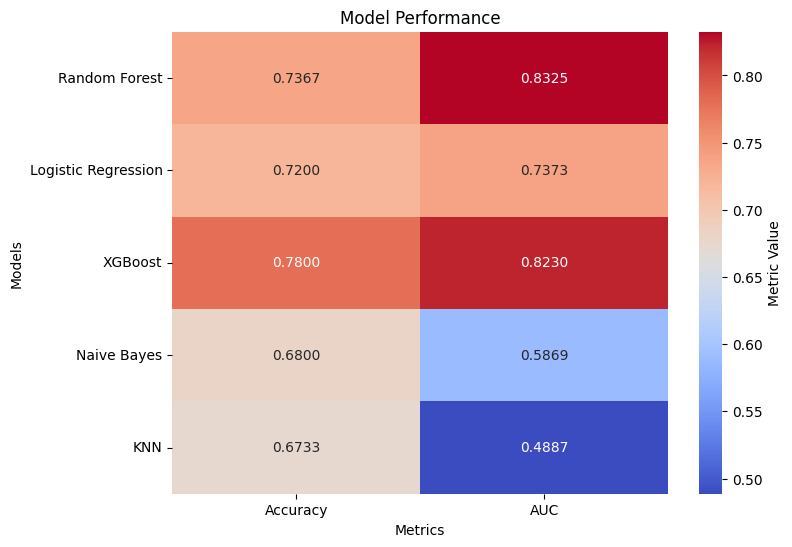

In [88]:
import seaborn as sns
metrics = np.array([accuracies, aucs]).T
metric_labels = ['Accuracy', 'AUC']

plt.figure(figsize=(8, 6))
sns.heatmap(metrics, annot=True, fmt=".4f", cmap="coolwarm", xticklabels=metric_labels, yticklabels=models, cbar_kws={'label': 'Metric Value'})
plt.title("Model Performance")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.show()


In [84]:
best_model_index = np.argmax(aucs)
best_model = models[best_model_index]
print(f"The best model for fraud detection is: {best_model} with an AUC of {aucs[best_model_index]:.4f}")


The best model for fraud detection is: Random Forest with an AUC of 0.8325
